In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt, dates

In [2]:
def currency(x, pos):
    """The two args are the value and tick position"""
    if x >= 1e6:
        s = '${:1.1f}M'.format(x*1e-6)
    else:
        s = '${:1.0f}K'.format(x*1e-3)
    return s

In [21]:
gmx_arb = pd.read_csv('data/GMX_Arbitrum_Fees_2021-08-31_2022-07-05.csv')
gmx_avax = pd.read_csv('data/GMX_Avax_Fees_2022-01-06_2022-07-05.csv')
gmx_price_raw = pd.read_csv('data/gmx-usd-price.csv')
gmx_arb_staked = pd.read_csv('data/gmx_staked_arbi.csv')
gmx_avax_staked = pd.read_csv('data/gmx_staked_avax.csv')
eth_price = pd.read_csv('data/eth-usd-max.csv')
gmx_arb.head()

,Date,Swap,Margin trading,Mint GLP,Burn GLP,Liquidation,Cumulative
0,2021-08-31,0.399321,0.153256,0.118304,0.206160,0.0,0.877041
1,2021-09-01,866.365339,101.848845,4843.226667,0.033713,0.0,5812.351605
2,2021-09-02,854.002762,741.708859,1610.527787,134.264965,0.0,9152.855978
3,2021-09-03,1388.241363,3127.266851,22.380404,0.000000,0.0,13690.744595
4,2021-09-04,219.024733,768.756821,82.883759,0.000000,0.0,14761.409908


<AxesSubplot:title={'center':'Weekly GMX Revenue Avax'}, xlabel='Week', ylabel='Revenue'>

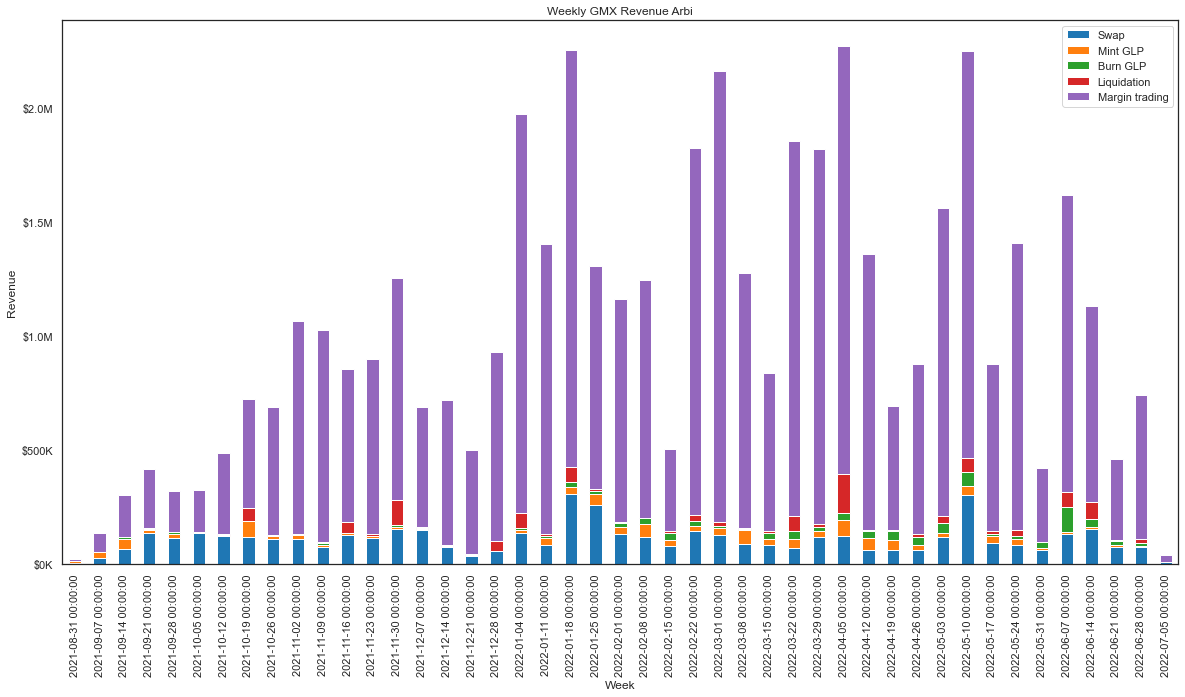

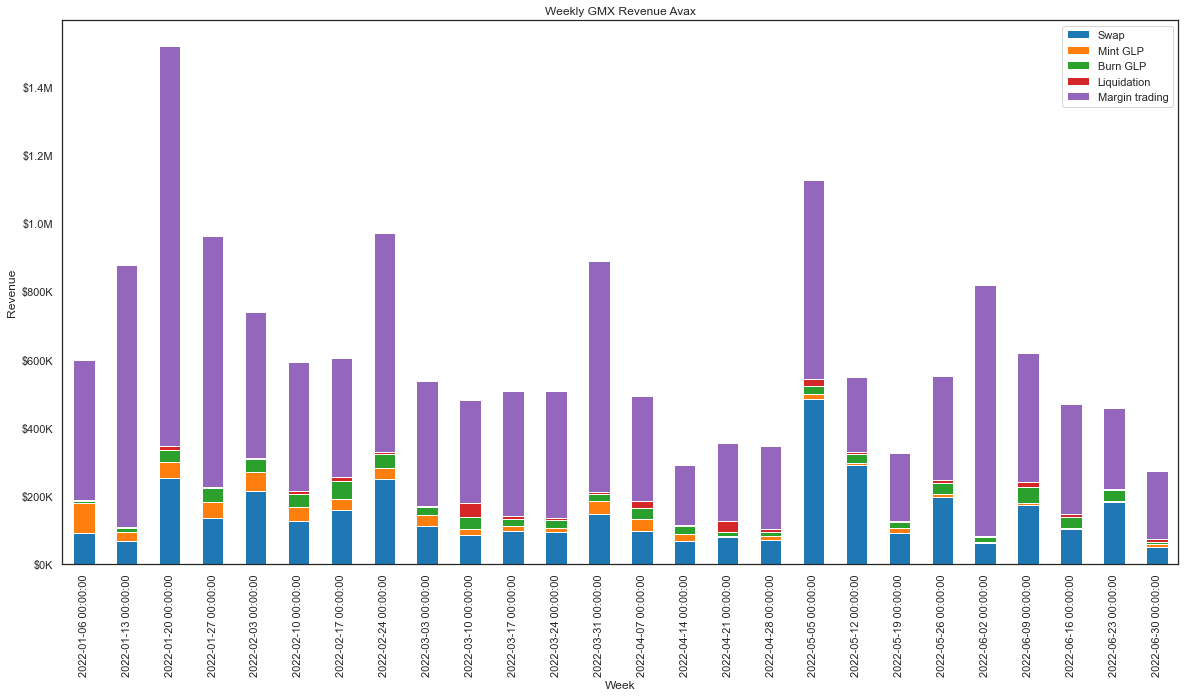

In [67]:
plt.rcParams["figure.figsize"] = [20, 10]
# plt.rcParams.update({'font.size': 50})
sns.set_theme(style="white", palette=None)

def weekly_chain_rev(chain, gmx_data):
    gmx_data.index = pd.to_datetime(gmx_data['Date'])
    gmx_data_res = gmx_data.resample('7D').sum()

    cum_fee = gmx_data_res[['Swap',  'Mint GLP', 'Burn GLP', 'Liquidation','Margin trading']].plot(kind='bar', stacked=True)
    cum_fee.set( 
           xlabel='Week', 
           ylabel='Revenue',
           title=f'Weekly GMX Revenue {chain}')
    cum_fee.yaxis.set_major_formatter(currency)
    # cum_fee_arb.xaxis.set_major_formatter(dates.DateFormatter('%Y-%m-%d'))
    return cum_fee

weekly_chain_rev('Arbi', gmx_arb)
weekly_chain_rev('Avax', gmx_avax)

,Date,Swap,Margin trading,Mint GLP,Burn GLP,Liquidation,Cumulative
0,2022-01-06,243.731498,1841.619851,46512.034412,61.256909,0.111774,4.865875e+04
1,2022-01-07,8361.350661,8681.586268,5877.247515,1085.867040,1456.046912,7.412085e+04
2,2022-01-08,12425.608911,12073.865951,3506.106376,957.728451,422.364682,1.035065e+05
3,2022-01-09,13572.463907,79978.143009,4695.073079,181.761533,0.624591,2.019346e+05
4,2022-01-10,23276.360026,128402.302896,4230.024692,242.779077,425.566029,3.585116e+05
...,...,...,...,...,...,...,...
176,2022-07-01,18111.606685,49224.103433,165.863430,1587.822941,1757.887105,1.633786e+07
177,2022-07-02,1733.926201,14223.760698,129.582623,10.579650,1.024002,1.635396e+07
178,2022-07-03,7596.567502,23309.098000,468.168532,267.875061,3.776040,1.638560e+07
179,2022-07-04,7768.291149,44067.382693,208.239270,358.921068,184.233508,1.643819e+07


In [112]:
eth_price = pd.read_csv('data/eth-usd-max.csv')
gmx_price_raw = pd.read_csv('data/gmx-usd-price.csv')

gmx_price_raw.index = pd.to_datetime(gmx_price_raw['Date'])
gmx_price_raw.index = gmx_price_raw.index.tz_localize(None)
gmx_price = gmx_price_raw.drop(['Date'], axis=1)

eth_price.index = pd.to_datetime(eth_price['snapped_at'])
eth_price.index = eth_price.index.tz_localize(None)
eth_price = eth_price.drop(['snapped_at'], axis=1)
eth_price. rename(columns = {'price':'price_eth'}, inplace = True)

def gmx_yield(gmx_data, chain_staked_table, chain, eth_price):
    
    gmx_total_fee = pd.DataFrame(gmx_data.set_index('Date').drop(['Cumulative'], axis=1).sum(axis=1)*0.3)
    gmx_total_fee.columns = ['GMX_fee']
    
    chain_staked_table['time'] = pd.to_datetime(chain_staked_table['time'], unit='s')
    chain_staked_table = chain_staked_table.sort_values(by=['time']).set_index('time').resample('1D').mean().dropna()
    

    master_df = pd.merge(gmx_price, gmx_total_fee, left_index=True, right_index=True)
    master_df = pd.merge(chain_staked_table[['balance']], master_df, left_index=True, right_index=True)
    master_df = pd.merge(eth_price[['price_eth']], master_df, left_index=True, right_index=True)

    
    master_df['EPS_daily'] = master_df.GMX_fee / master_df.balance
    master_df['EPS'] = master_df['EPS_daily']*365
    master_df['Forward P/E'] = master_df.price/master_df.EPS
    master_df['ARR'] = master_df.EPS/master_df.price

    if chain == 'avax':
        master_df = master_df[(master_df.index > '2022-02-01')]
    
    return master_df


arbi_data = gmx_yield(gmx_arb, gmx_arb_staked, 'arbi', eth_price)
avax_data = gmx_yield(gmx_avax, gmx_avax_staked, 'avax', eth_price)

arbi_data.describe()
avax_data.describe()

,price_eth,balance,price,GMX_fee,EPS_daily,EPS,Forward P/E,ARR
count,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000
mean,2443.959569,375240.639921,27.152201,24853.591918,0.068736,25.088711,1.616981,0.949805
std,715.849793,46231.894018,8.069566,20403.395921,0.057977,21.161642,1.137061,0.806287
min,995.252569,215108.341500,13.204908,4430.614949,0.010566,3.856672,0.138905,0.124907
25%,1922.402534,354027.631475,20.363260,14177.331990,0.037079,13.533993,0.900856,0.512831
50%,2679.512859,379979.508417,27.428537,20122.535907,0.051706,18.872702,1.318375,0.758510
75%,2991.398799,399936.591619,33.015006,29107.129316,0.077832,28.408676,1.949984,1.110055
max,3521.584725,463764.737400,45.656521,184025.500166,0.447701,163.410778,8.005954,7.199145


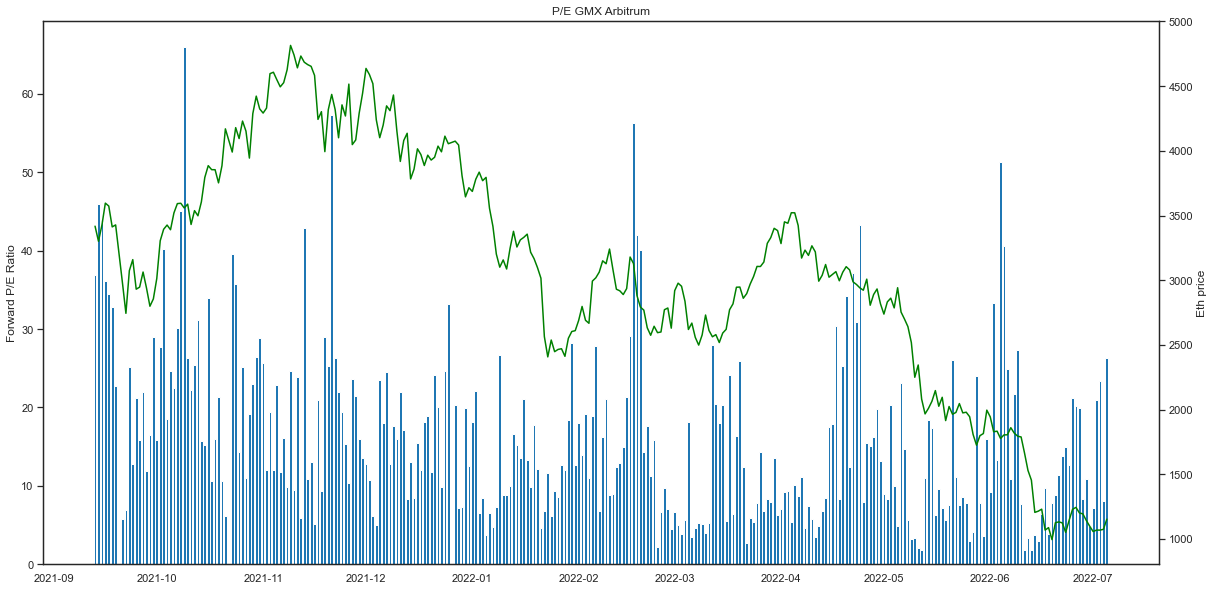

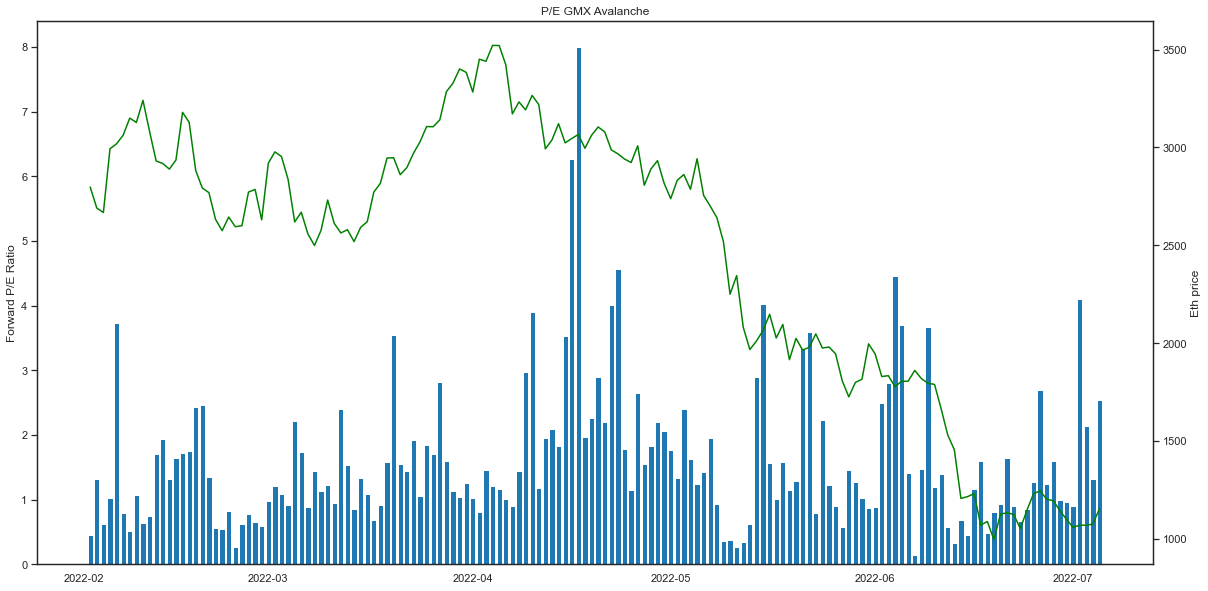

In [89]:
def p_e_graph(chain, data):
    plt.bar(data.index, data['Forward P/E'], label="P/E")
    plt.title(f'P/E GMX {chain}')
    plt.ylabel('Forward P/E Ratio')
    eth_p = plt.twinx()
    eth_p.plot(data.index, data['price_eth'], color='green', label="eth_price")
    eth_p.set_ylabel('Eth price')
    return plt.show()

p_e_graph('Arbitrum', arbi_data)
p_e_graph('Avalanche', avax_data)


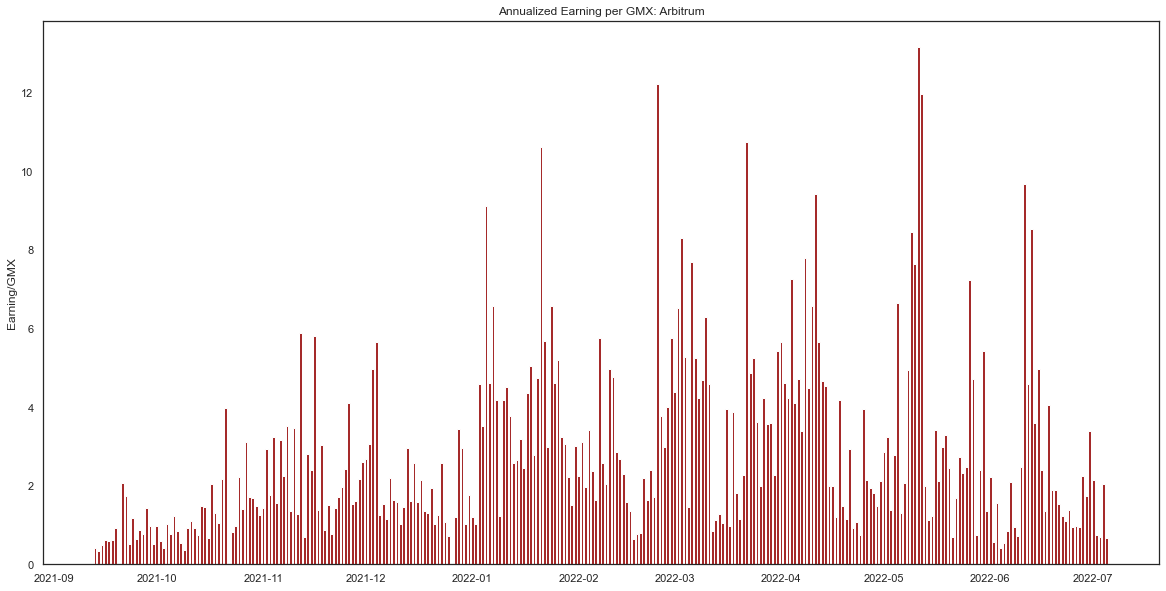

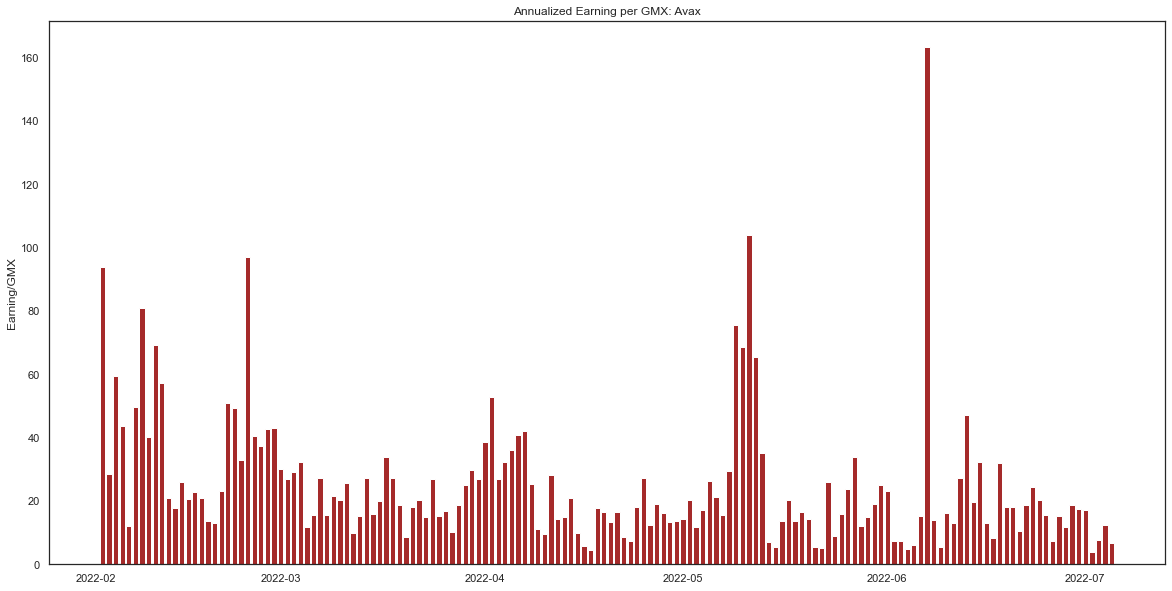

In [94]:
plt.bar(arbi_data.index, arbi_data['EPS'], color='brown')
plt.title('Annualized Earning per GMX: Arbitrum')
plt.ylabel('Earning/GMX')
plt.show()

plt.bar(avax_data.index, avax_data['EPS'], color='brown')
plt.title('Annualized Earning per GMX: Avax')
plt.ylabel('Earning/GMX')
plt.show()

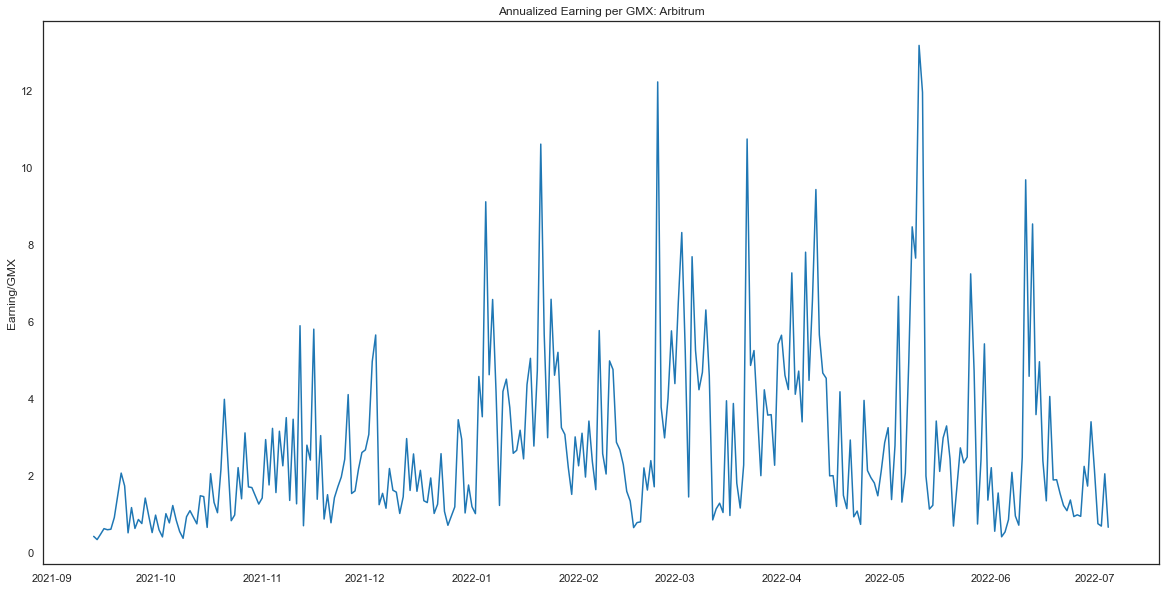

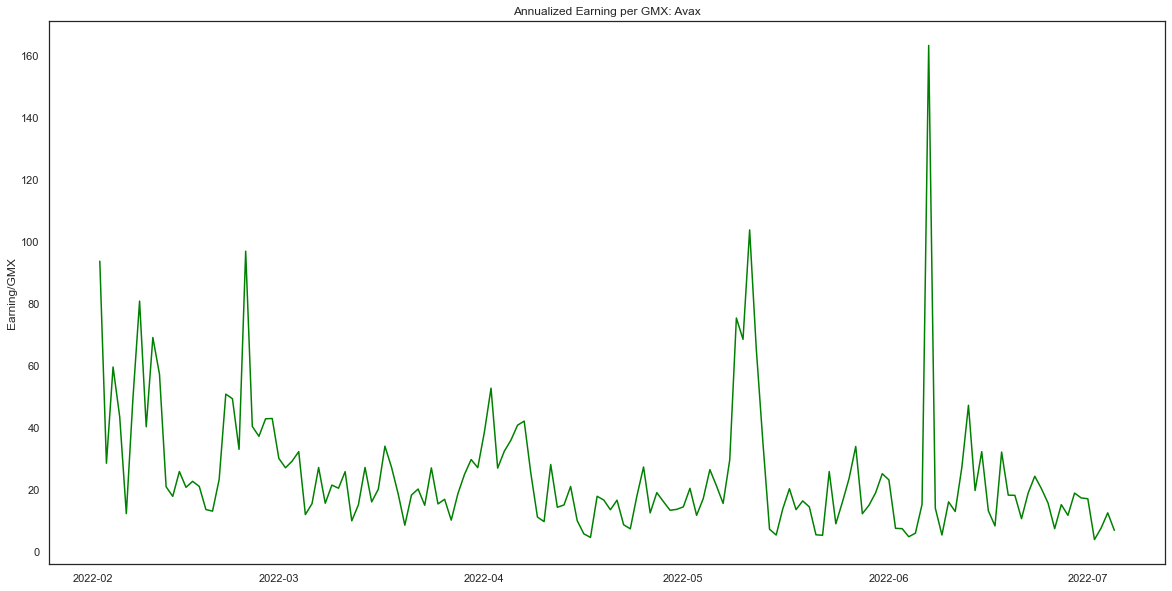

In [8]:
plt.plot(arbi_data.index, arbi_data['E_coin_ann'])
plt.title('Annualized Earning per GMX: Arbitrum')
plt.ylabel('Earning/GMX')
plt.show()

plt.plot(avax_data.index, avax_data['E_coin_ann'], color='green')
plt.title('Annualized Earning per GMX: Avax')
plt.ylabel('Earning/GMX')
plt.show()

<AxesSubplot:>

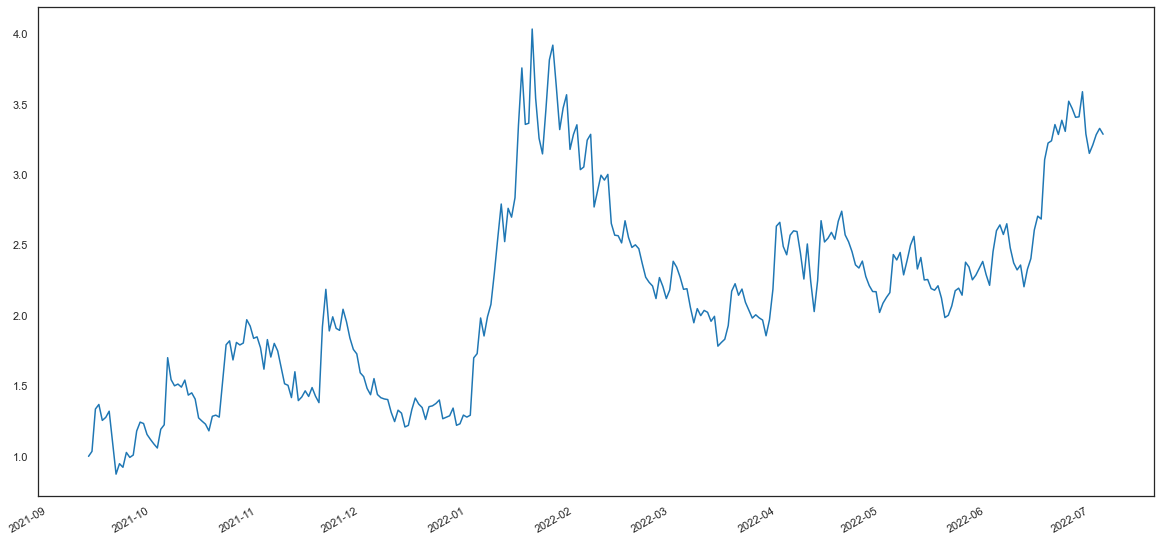

In [103]:
gmx_eth = arbi_data.price/arbi_data.price_eth
gmx_eth = gmx_eth/gmx_eth[0]
gmx_eth.plot()


<AxesSubplot:>

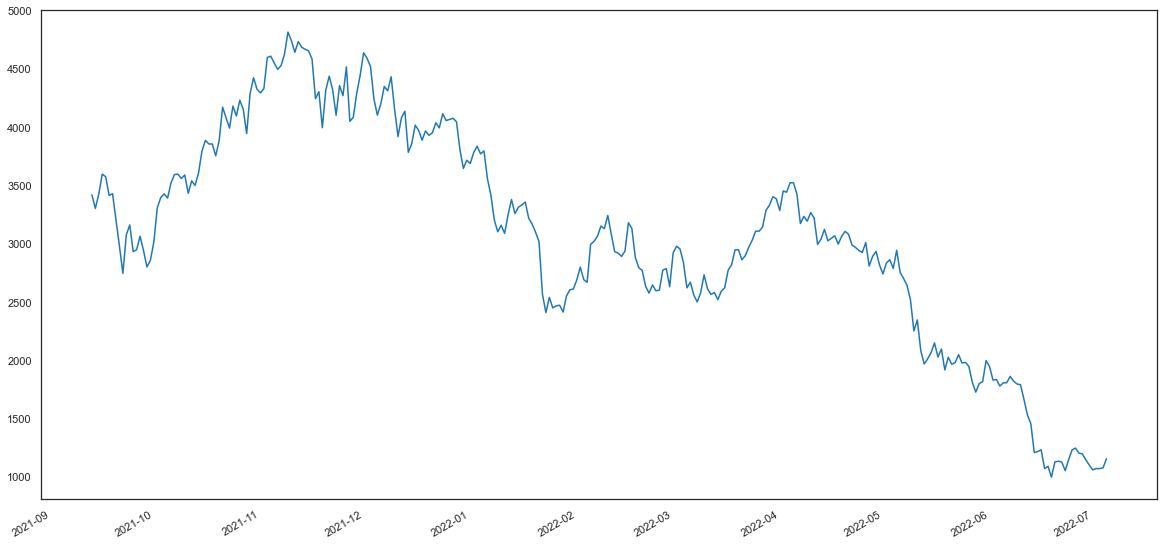

In [105]:
arbi_data.price_eth.plot()